In [2]:

# COMPILAR DESDE GOOGLE COLAB
"""from google.colab import files
import pandas as pd

print("Selecciona archivo deptos_out.csv")
up = files.upload()
csv_path = list(up.keys())[0]


df = pd.read_csv(csv_path, encoding="utf-8-sig")"""


#COMPILAR DESDE LOCAL (EXTENSIÓN JUPYTER VSCODE)
import pandas as pd

# Cargar directamente desde la ruta local
df_basico = pd.read_csv('propiedades_portal_inmobiliario.csv', encoding='utf-8-sig')
df_detalle = pd.read_csv('propiedades_detalle_caracteristicas.csv', encoding='utf-8-sig')

# Merge por el link
df = pd.merge(df_basico, df_detalle, on='link', how='left')

print(f"Filas, Columnas: {df.shape}")
df.head(10)


Filas, Columnas: (2016, 8)


,link,titulo,precio,moneda,superficie_util,superficie_total,dormitorios,banos
0,https://portalinmobiliario.com/MLC-2937998712-...,Departamento Amoblado - Espoz,81,UF,220 m²,260 m²,3,3
1,https://portalinmobiliario.com/MLC-3060993802-...,Santa Teresita,79,UF,245 m²,275 m²,3,4
2,https://portalinmobiliario.com/MLC-1684873563-...,"Departamento En Arriendo En San Damián, Sector...",1300000,$,70 m²,80 m²,2,2
3,https://portalinmobiliario.com/MLC-2986729402-...,Moderno Departamento En Arriendo El Golf,34,UF,70 m²,100 m²,1,2
4,https://portalinmobiliario.com/MLC-3152851514-...,Av. Santa Maria - Capellán Abazúa,950000,$,108 m²,108 m²,4,2
5,https://portalinmobiliario.com/MLC-1683529617-...,Departamento Mario Kreutzberger Id: 89490,335000,$,28 m²,28 m²,1,1
6,https://portalinmobiliario.com/MLC-2909038572-...,Aeropuerto,425000,$,70 m²,77 m²,3,2
7,https://portalinmobiliario.com/MLC-1676555479-...,Departamento Zañartu Id: 24728,390000,$,33 m²,36 m²,1,1
8,https://portalinmobiliario.com/MLC-1710244033-...,Departamento En Arriendo En Las Condes,9000,US$,360 m²,500 m²,4,5
9,https://portalinmobiliario.com/MLC-1711467089-...,Departamento En Arriendo De 3 Dorm. En Las Condes,65,UF,250 m²,337 m²,3,4


In [3]:
print("Filas, Columnas:", df.shape)
display(df.head(10))
print("\nColumnas:")
print(list(df.columns))

Filas, Columnas: (2016, 8)


,link,titulo,precio,moneda,superficie_util,superficie_total,dormitorios,banos
0,https://portalinmobiliario.com/MLC-2937998712-...,Departamento Amoblado - Espoz,81,UF,220 m²,260 m²,3,3
1,https://portalinmobiliario.com/MLC-3060993802-...,Santa Teresita,79,UF,245 m²,275 m²,3,4
2,https://portalinmobiliario.com/MLC-1684873563-...,"Departamento En Arriendo En San Damián, Sector...",1300000,$,70 m²,80 m²,2,2
3,https://portalinmobiliario.com/MLC-2986729402-...,Moderno Departamento En Arriendo El Golf,34,UF,70 m²,100 m²,1,2
4,https://portalinmobiliario.com/MLC-3152851514-...,Av. Santa Maria - Capellán Abazúa,950000,$,108 m²,108 m²,4,2
5,https://portalinmobiliario.com/MLC-1683529617-...,Departamento Mario Kreutzberger Id: 89490,335000,$,28 m²,28 m²,1,1
6,https://portalinmobiliario.com/MLC-2909038572-...,Aeropuerto,425000,$,70 m²,77 m²,3,2
7,https://portalinmobiliario.com/MLC-1676555479-...,Departamento Zañartu Id: 24728,390000,$,33 m²,36 m²,1,1
8,https://portalinmobiliario.com/MLC-1710244033-...,Departamento En Arriendo En Las Condes,9000,US$,360 m²,500 m²,4,5
9,https://portalinmobiliario.com/MLC-1711467089-...,Departamento En Arriendo De 3 Dorm. En Las Condes,65,UF,250 m²,337 m²,3,4



Columnas:
['link', 'titulo', 'precio', 'moneda', 'superficie_util', 'superficie_total', 'dormitorios', 'banos']


In [4]:
import pandas as pd

cols_deseadas = ["precio","moneda","superficie_util","superficie_total","dormitorios","banos"]
cols_existentes = [c for c in cols_deseadas if c in df.columns]

df_modelo = df[cols_existentes].copy()

print("Columnas usadas:", cols_existentes)
print("Filas, Columnas:", df_modelo.shape)
display(df_modelo.head(10))

Columnas usadas: ['precio', 'moneda', 'superficie_util', 'superficie_total', 'dormitorios', 'banos']
Filas, Columnas: (2016, 6)


,precio,moneda,superficie_util,superficie_total,dormitorios,banos
0,81,UF,220 m²,260 m²,3,3
1,79,UF,245 m²,275 m²,3,4
2,1300000,$,70 m²,80 m²,2,2
3,34,UF,70 m²,100 m²,1,2
4,950000,$,108 m²,108 m²,4,2
5,335000,$,28 m²,28 m²,1,1
6,425000,$,70 m²,77 m²,3,2
7,390000,$,33 m²,36 m²,1,1
8,9000,US$,360 m²,500 m²,4,5
9,65,UF,250 m²,337 m²,3,4


In [8]:
# Análisis Exploratorio
import numpy as np

# 1. Completitud de datos por variable
print("=== COMPLETITUD DE DATOS ===")
completitud = (df_modelo.notna().sum() / len(df_modelo) * 100).round(1)
for col, pct in completitud.items():
    print(f"{col:20} {pct:5.1f}% completo")

# 2. Estadísticas descriptivas
print("\n=== ESTADÍSTICAS DESCRIPTIVAS ===")
display(df_modelo.describe())

# 3. Distribución de precios
print("\n=== DISTRIBUCIÓN DE PRECIOS ===")
print(f"Media: ${df_modelo['precio'].mean():,.0f}")
print(f"Mediana: ${df_modelo['precio'].median():,.0f}")
print(f"Q1-Q3: ${df_modelo['precio'].quantile(0.25):,.0f} - ${df_modelo['precio'].quantile(0.75):,.0f}")

# 4. Correlaciones (solo columnas numéricas)
print("\n=== CORRELACIÓN CON PRECIO ===")
df_num = df_modelo.select_dtypes(include=[np.number])
if 'precio' in df_num.columns:
    corr_precio = df_num.corr()['precio'].sort_values(ascending=False)
    print(corr_precio)

# 5. Análisis por comuna (extraer de titulo/direccion)
print("\n=== REPRESENTATIVIDAD POR COMUNA ===")

# Intentar extraer comuna del título y dirección
import re

comunas_rm = ['providencia','las condes','vitacura','ñuñoa','la reina','lo barnechea',
              'peñalolén','macul','la florida','santiago','independencia','recoleta',
              'conchalí','huechuraba','quinta normal','estación central','cerrillos',
              'maipú','pudahuel','lo prado','renca','quilicura','cerro navia',
              'san miguel','la cisterna','san joaquín','pedro aguirre cerda',
              'lo espejo','san ramón','la granja','el bosque','la pintana',
              'san bernardo','puente alto']

def extraer_comuna(row):
    # Buscar en título y dirección
    texto = f"{row.get('titulo', '')} {row.get('direccion', '')}".lower()
    for comuna in comunas_rm:
        if comuna in texto:
            return comuna.title()
    return 'No especificada'

df['comuna_extraida'] = df.apply(extraer_comuna, axis=1)
props_comuna = df['comuna_extraida'].value_counts()
total_props = len(df)

print(f"Total propiedades: {total_props}")
print(f"Comunas identificadas: {props_comuna.nunique()-1}")  # -1 por 'No especificada'
print(f"\nTop 10 comunas:")
for comuna, count in props_comuna.head(10).items():
    pct = count/total_props*100
    representativa = "✓" if count >= 30 else "⚠️"
    print(f"{representativa} {comuna:22} {count:4} props ({pct:5.1f}%)")

# Advertencia sobre comunas con poca data
comunas_pocas = props_comuna[(props_comuna < 30) & (props_comuna.index != 'No Especificada')]
print(f"\n⚠️ {len(comunas_pocas)} comunas con <30 propiedades (baja representatividad)")

no_especificadas = props_comuna.get('No Especificada', 0)
if no_especificadas > 0:
    print(f"⚠️ {no_especificadas} propiedades sin comuna ({no_especificadas/total_props*100:.1f}%)")
    
print(f"\n✓ Recomendación: Usar geocodificación para identificar comunas de manera precisa")

=== COMPLETITUD DE DATOS ===
precio               100.0% completo
moneda               100.0% completo
superficie_util      100.0% completo
superficie_total     100.0% completo
dormitorios          100.0% completo
banos                100.0% completo

=== ESTADÍSTICAS DESCRIPTIVAS ===


,precio,dormitorios,banos
count,2.016000e+03,2016.000000,2016.000000
mean,4.114179e+05,1.884921,1.619544
std,4.470477e+05,0.979518,0.916133
min,6.000000e+00,0.000000,0.000000
25%,2.300000e+05,1.000000,1.000000
50%,3.500000e+05,2.000000,1.000000
75%,4.800000e+05,2.000000,2.000000
max,6.000000e+06,7.000000,7.000000



=== DISTRIBUCIÓN DE PRECIOS ===
Media: $411,418
Mediana: $350,000
Q1-Q3: $230,000 - $480,000

=== CORRELACIÓN CON PRECIO ===
precio         1.000000
dormitorios    0.147946
banos          0.139448
Name: precio, dtype: float64

=== REPRESENTATIVIDAD POR COMUNA ===
Total propiedades: 2016
Comunas identificadas: 19

Top 10 comunas:
✓ No especificada        1566 props ( 77.7%)
✓ Las Condes               94 props (  4.7%)
✓ Santiago                 86 props (  4.3%)
✓ Ñuñoa                    58 props (  2.9%)
⚠️ Macul                    29 props (  1.4%)
⚠️ Vitacura                 28 props (  1.4%)
⚠️ Independencia            26 props (  1.3%)
⚠️ Providencia              24 props (  1.2%)
⚠️ San Miguel               20 props (  1.0%)
⚠️ La Florida               17 props (  0.8%)

⚠️ 20 comunas con <30 propiedades (baja representatividad)

✓ Recomendación: Usar geocodificación para identificar comunas de manera precisa


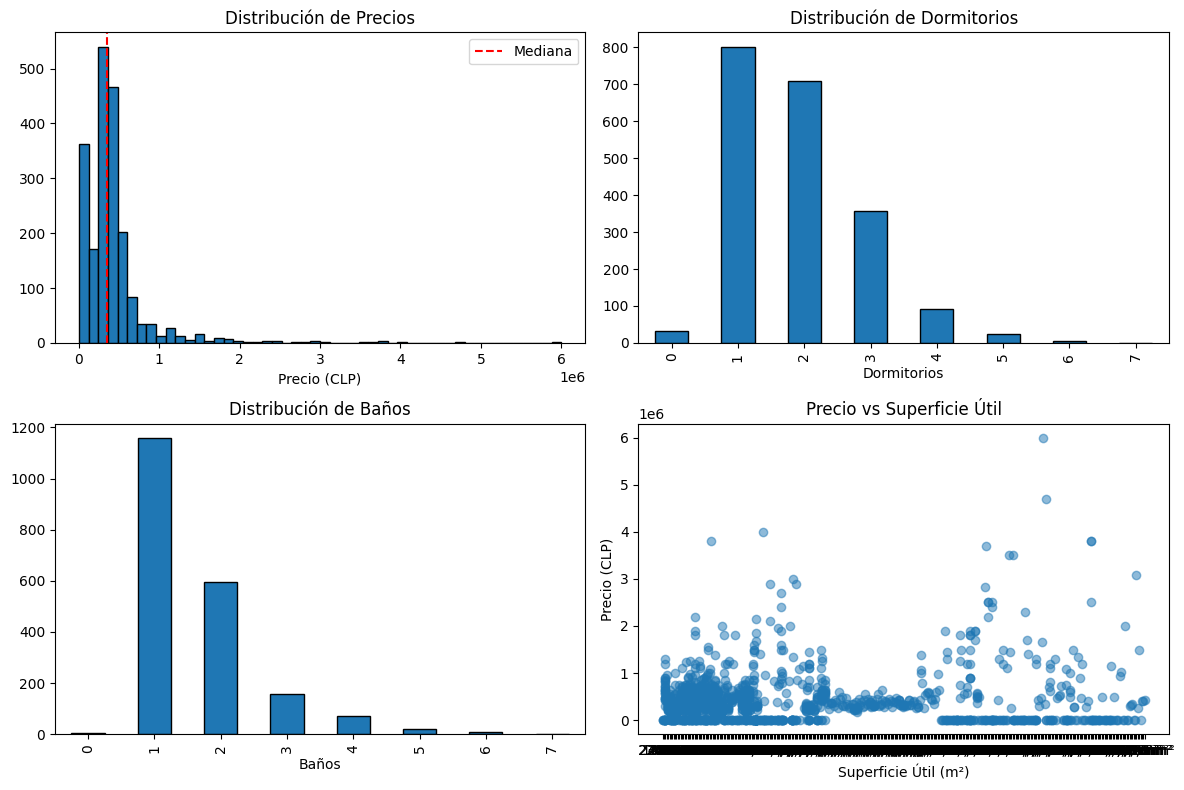

✓ Análisis exploratorio completado


In [7]:
# Visualización de distribuciones
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Precio
axes[0,0].hist(df_modelo['precio'], bins=50, edgecolor='black')
axes[0,0].set_title('Distribución de Precios')
axes[0,0].set_xlabel('Precio (CLP)')
axes[0,0].axvline(df_modelo['precio'].median(), color='red', linestyle='--', label='Mediana')
axes[0,0].legend()

# Dormitorios
df_modelo['dormitorios'].value_counts().sort_index().plot(kind='bar', ax=axes[0,1], edgecolor='black')
axes[0,1].set_title('Distribución de Dormitorios')
axes[0,1].set_xlabel('Dormitorios')

# Baños
df_modelo['banos'].value_counts().sort_index().plot(kind='bar', ax=axes[1,0], edgecolor='black')
axes[1,0].set_title('Distribución de Baños')
axes[1,0].set_xlabel('Baños')

# Scatter precio vs superficie
axes[1,1].scatter(df_modelo['superficie_util'], df_modelo['precio'], alpha=0.5)
axes[1,1].set_title('Precio vs Superficie Útil')
axes[1,1].set_xlabel('Superficie Útil (m²)')
axes[1,1].set_ylabel('Precio (CLP)')

plt.tight_layout()
plt.show()

print("✓ Análisis exploratorio completado")

In [ ]:
# Enriquecer datos usando geocodificación (solo para registros sin comuna)
!pip install -q geopy

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
import time

# Coordenadas de comunas RM (fallback) - TODAS las 52 comunas
coordenadas_comunas = {
    'Providencia': (-33.4372, -70.6106), 'Las Condes': (-33.4166, -70.5833),
    'Vitacura': (-33.3833, -70.5833), 'Ñuñoa': (-33.4569, -70.5978),
    'La Reina': (-33.4500, -70.5333), 'Lo Barnechea': (-33.3500, -70.5167),
    'Peñalolén': (-33.4969, -70.5167), 'Macul': (-33.4914, -70.5978),
    'La Florida': (-33.5242, -70.5989), 'Santiago': (-33.4372, -70.6506),
    'Independencia': (-33.4167, -70.6667), 'Recoleta': (-33.4167, -70.6333),
    'Conchalí': (-33.3833, -70.6667), 'Huechuraba': (-33.3667, -70.6333),
    'Quinta Normal': (-33.4333, -70.7000), 'Estación Central': (-33.4667, -70.6833),
    'Cerrillos': (-33.4972, -70.7167), 'Maipú': (-33.5108, -70.7578),
    'Pudahuel': (-33.4403, -70.7500), 'Lo Prado': (-33.4500, -70.7333),
    'Renca': (-33.4000, -70.7167), 'Quilicura': (-33.3611, -70.7306),
    'Cerro Navia': (-33.4167, -70.7333), 'San Miguel': (-33.4969, -70.6533),
    'La Cisterna': (-33.5333, -70.6667), 'San Joaquín': (-33.4969, -70.6322),
    'Pedro Aguirre Cerda': (-33.4833, -70.6833), 'Lo Espejo': (-33.5167, -70.6833),
    'San Ramón': (-33.5394, -70.6458), 'La Granja': (-33.5333, -70.6167),
    'El Bosque': (-33.5667, -70.6667), 'La Pintana': (-33.5833, -70.6333),
    'San Bernardo': (-33.5925, -70.7000), 'Puente Alto': (-33.6167, -70.5833),
    'Colina': (-33.1961, -70.6747), 'Lampa': (-33.2861, -70.8761),
    'Tiltil': (-33.0833, -70.9333), 'Curacaví': (-33.4000, -71.1333),
    'María Pinto': (-33.5167, -71.1167), 'Melipilla': (-33.6833, -71.2167),
    'San Pedro': (-33.8833, -71.4667), 'Alhué': (-34.0167, -71.0833),
    'Talagante': (-33.6667, -70.9333), 'El Monte': (-33.6833, -71.0167),
    'Isla de Maipo': (-33.7500, -70.9000), 'Padre Hurtado': (-33.5667, -70.8167),
    'Peñaflor': (-33.6167, -70.8833), 'Pirque': (-33.6667, -70.5833),
    'San José de Maipo': (-33.6417, -70.3547), 'Buin': (-33.7333, -70.7500),
    'Paine': (-33.8167, -70.7333), 'Calera de Tango': (-33.6333, -70.7667),
    'Otra': (-33.4489, -70.6693)
}

mapeo_comunas = {
    'providencia': 'Providencia', 'las condes': 'Las Condes',
    'vitacura': 'Vitacura', 'ñuñoa': 'Ñuñoa', 'nunoa': 'Ñuñoa',
    'la reina': 'La Reina', 'lo barnechea': 'Lo Barnechea',
    'peñalolén': 'Peñalolén', 'penalolen': 'Peñalolén',
    'macul': 'Macul', 'la florida': 'La Florida',
    'santiago': 'Santiago', 'independencia': 'Independencia',
    'recoleta': 'Recoleta', 'conchalí': 'Conchalí', 'conchali': 'Conchalí',
    'huechuraba': 'Huechuraba', 'quinta normal': 'Quinta Normal',
    'estación central': 'Estación Central', 'estacion central': 'Estación Central',
    'cerrillos': 'Cerrillos', 'maipú': 'Maipú', 'maipu': 'Maipú',
    'pudahuel': 'Pudahuel', 'lo prado': 'Lo Prado', 'renca': 'Renca',
    'quilicura': 'Quilicura', 'cerro navia': 'Cerro Navia',
    'san miguel': 'San Miguel', 'la cisterna': 'La Cisterna',
    'san joaquín': 'San Joaquín', 'san joaquin': 'San Joaquín',
    'pedro aguirre cerda': 'Pedro Aguirre Cerda', 'lo espejo': 'Lo Espejo',
    'san ramón': 'San Ramón', 'san ramon': 'San Ramón',
    'la granja': 'La Granja', 'el bosque': 'El Bosque',
    'la pintana': 'La Pintana', 'san bernardo': 'San Bernardo',
    'puente alto': 'Puente Alto'
}

geolocator = Nominatim(user_agent="data_science_rm", timeout=10)
geocode_cache = {}

def geocode_y_extraer_comuna(row):
    """Geocodifica dirección y extrae comuna via reverse geocoding"""
    titulo = row.get('titulo', '')
    
    # Construir query desde título
    query = f"{titulo}, Santiago, Chile"
    
    # Cache
    if query in geocode_cache:
        return geocode_cache[query]
    
    try:
        # Geocoding
        location = geolocator.geocode(query)
        if location:
            # Reverse geocoding para obtener comuna
            time.sleep(1.1)  # Rate limiting
            reverse = geolocator.reverse((location.latitude, location.longitude), language='es')
            
            if reverse and reverse.raw.get('address'):
                address = reverse.raw['address']
                comuna_raw = (
                    address.get('suburb') or address.get('municipality') or 
                    address.get('city_district') or address.get('town') or 
                    address.get('city') or 'No Especificada'
                )
                
                # Normalizar
                comuna_norm = mapeo_comunas.get(comuna_raw.lower().strip(), 'No Especificada')
                resultado = (location.latitude, location.longitude, comuna_norm)
                geocode_cache[query] = resultado
                return resultado
    except:
        pass
    
    return (None, None, 'No Especificada')

# Aplicar geocodificación a TODOS los registros sin comuna
sin_comuna = df['comuna_extraida'].str.lower().str.contains('no especificada', na=False)
total_sin_comuna = sin_comuna.sum()

print(f"Total registros sin comuna: {total_sin_comuna}")

if total_sin_comuna > 0:
    registros_procesar = df[sin_comuna]
    tiempo_estimado = (total_sin_comuna * 1.1) / 60  # segundos a minutos
    
    print(f"Procesando TODOS los {len(registros_procesar)} registros...")
    print(f"Tiempo estimado: {tiempo_estimado:.1f} minutos (rate limit: 1 req/seg)")
    print("Puedes tomar un café ☕ mientras esto se ejecuta...\n")
    
    resultados = []
    for idx, (row_idx, row) in enumerate(registros_procesar.iterrows()):
        if idx % 50 == 0:
            progreso = (idx / len(registros_procesar)) * 100
            print(f"  {idx}/{len(registros_procesar)} procesados ({progreso:.1f}%)...")
        
        lat, lon, comuna = geocode_y_extraer_comuna(row)
        resultados.append({'index': row_idx, 'lat': lat, 'lon': lon, 'comuna_geo': comuna})
    
    # Actualizar dataframe
    if resultados:
        df_geo = pd.DataFrame(resultados).set_index('index')
        df.loc[df_geo.index, 'comuna_mejorada'] = df_geo['comuna_geo']
        df.loc[df_geo.index, 'lat'] = df_geo['lat']
        df.loc[df_geo.index, 'lon'] = df_geo['lon']
        
        print(f"\n✓ Geocodificación completada")
        print(f"  Registros procesados: {len(registros_procesar)}")
        print(f"  Comunas nuevas identificadas: {(df_geo['comuna_geo'] != 'No Especificada').sum()}")
        print(f"  Coordenadas obtenidas: {df_geo['lat'].notna().sum()}")
        print(f"  Consultas en cache: {len(geocode_cache)}")
else:
    print("⚠️ Todos los registros ya tienen comuna identificada")

# Consolidar columna comuna final (normalizar mayúsculas)
if 'comuna_mejorada' in df.columns:
    df['comuna_final'] = df['comuna_mejorada'].fillna(df['comuna_extraida'])
else:
    df['comuna_final'] = df['comuna_extraida']

# Normalizar nombres duplicados
df['comuna_final'] = df['comuna_final'].replace({
    'no especificada': 'No Especificada',
    'No especificada': 'No Especificada'
})

print(f"\n=== REPRESENTATIVIDAD MEJORADA ===")
props_mejorada = df['comuna_final'].value_counts()
total_con_comuna = (props_mejorada.index != 'No Especificada').sum()

print(f"Comunas identificadas: {total_con_comuna}")
print(f"Sin comuna: {props_mejorada.get('No Especificada', 0)} ({props_mejorada.get('No Especificada', 0)/len(df)*100:.1f}%)\n")

print("Top 10 comunas:")
for comuna, count in props_mejorada.head(10).items():
    pct = count/len(df)*100
    rep = "✓" if count >= 30 else "⚠️"
    print(f"{rep} {comuna:22} {count:4} props ({pct:5.1f}%)")

# Guardar coordenadas para uso posterior
if 'lat' in df.columns and 'lon' in df.columns:
    coords_disponibles = df[['lat', 'lon']].notna().all(axis=1).sum()
    print(f"\n✓ {coords_disponibles} registros con coordenadas geográficas ({coords_disponibles/len(df)*100:.1f}%)")


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Total registros sin comuna: 1566
Procesando muestra de 50 registros (rate limit: 1 req/seg)...
Esto tomará aprox. 1-2 minutos...

  0/50 procesados...
  5/50 procesados...
  5/50 procesados...
  10/50 procesados...
  10/50 procesados...
  15/50 procesados...
  15/50 procesados...
  20/50 procesados...
  20/50 procesados...
  25/50 procesados...
  25/50 procesados...
  30/50 procesados...
  30/50 procesados...
  35/50 procesados...
  35/50 procesados...
  40/50 procesados...
  40/50 procesados...
  45/50 procesados...
  45/50 procesados...

✓ Geocodificación completada
  Registros procesados: 50
  Comunas nuevas identificadas: 4
  Coordenadas obtenidas: 4

=== REPRESENTATIVIDAD MEJORADA ===
Comunas identificadas: 23
Sin comuna: 1562 (77.5%)

Top 10 comunas:
✓ No Especificada        1562 props ( 77.5%)
✓ Las Condes               94 props (  4.7%)
✓ Santiago                 89 props (  4.4%)
✓ Ñuñoa                    58 props (  2.9%)
⚠️ Macul                    29 props (  1.4%)
⚠️ Vita

In [21]:
# Obtener valor UF histórico y enriquecer datos
import requests
from datetime import datetime

# API para obtener UF
def obtener_valor_uf():
    try:
        url = "https://mindicador.cl/api/uf"
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            data = response.json()
            return data['serie'][0]['valor']
        else:
            return 38000  # valor aproximado fallback
    except:
        return 38000

valor_uf = obtener_valor_uf()
print(f"Valor UF actual: ${valor_uf:,.2f} CLP")

# Agregar valor UF al dataframe para conversión posterior
df['valor_uf_referencia'] = valor_uf

Valor UF actual: $39,643.59 CLP


In [22]:
# Convertir precios a UF y filtrar moneda
df_pesos = df_modelo.copy()
df_pesos["moneda_norm"] = df_pesos["moneda"].astype(str).str.strip()

# Filtrar solo pesos chilenos
df_pesos = df_pesos[df_pesos["moneda_norm"] == "$"].drop(columns=["moneda_norm"])

# Convertir precio a UF (variable más estable en el tiempo)
df_pesos['precio_uf'] = df_pesos['precio'] / valor_uf

print("Filas, Columnas (solo $):", df_pesos.shape)
print(f"\nPrecio promedio: ${df_pesos['precio'].mean():,.0f} CLP ({df_pesos['precio_uf'].mean():.2f} UF)")
display(df_pesos.head(10))

Filas, Columnas (solo $): (1653, 7)

Precio promedio: $501,742 CLP (12.66 UF)


,precio,moneda,superficie_util,superficie_total,dormitorios,banos,precio_uf
2,1300000,$,70 m²,80 m²,2,2,32.792187
4,950000,$,108 m²,108 m²,4,2,23.963521
5,335000,$,28 m²,28 m²,1,1,8.450294
6,425000,$,70 m²,77 m²,3,2,10.720523
7,390000,$,33 m²,36 m²,1,1,9.837656
11,750000,$,64 m²,64 m²,2,1,18.918569
12,150000,$,29 m²,32 m²,1,1,3.783714
13,250000,$,18 m²,35 m²,1,1,6.306190
14,290000,$,41 m²,45 m²,2,1,7.315180
16,280000,$,50 m²,52 m²,2,2,7.062932


In [26]:
import re
import numpy as np

def to_m2_float(x):
    if pd.isna(x):
        return np.nan
    s = str(x).lower()
    s = s.replace("m²", "").replace("m2", "").replace("m^2", "")
    s = s.replace(",", ".")
    nums = re.findall(r"\d*\.?\d+", s)
    if not nums:
        return np.nan
    vals = [float(n) for n in nums if n != ""]
    if not vals:
        return np.nan
    # si hay rango (varios números), usamos el promedio
    return float(np.mean(vals))

for col in ["superficie_util", "superficie_total"]:
    if col in df_pesos.columns:
        df_pesos[col] = df_pesos[col].apply(to_m2_float)

print("Tipos de datos tras conversión:")
display(df_pesos.dtypes)

print("\nMuestra convertida:")
display(df_pesos.head(10))

Tipos de datos tras conversión:


precio                int64
moneda               object
superficie_util     float64
superficie_total    float64
dormitorios           int64
banos                 int64
precio_uf           float64
dtype: object


Muestra convertida:


,precio,moneda,superficie_util,superficie_total,dormitorios,banos,precio_uf
2,1300000,$,70.0,80.0,2,2,32.792187
4,950000,$,108.0,108.0,4,2,23.963521
5,335000,$,28.0,28.0,1,1,8.450294
6,425000,$,70.0,77.0,3,2,10.720523
7,390000,$,33.0,36.0,1,1,9.837656
11,750000,$,64.0,64.0,2,1,18.918569
12,150000,$,29.0,32.0,1,1,3.783714
13,250000,$,18.0,35.0,1,1,6.306190
14,290000,$,41.0,45.0,2,1,7.315180
16,280000,$,50.0,52.0,2,2,7.062932


In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

df_arriendo = df_pesos.copy()

# Asegurar tipos numéricos
for col in ["dormitorios", "banos", "precio", "precio_uf"]:
    if col in df_arriendo.columns:
        df_arriendo[col] = pd.to_numeric(df_arriendo[col], errors="coerce")

# Completar superficies con ratio mediana
if {"superficie_util","superficie_total"}.issubset(df_arriendo.columns):
    ambos = df_arriendo[["superficie_util","superficie_total"]].dropna()
    ratio_mediana = (ambos["superficie_total"] / ambos["superficie_util"]).clip(0.6, 2.5).median() if len(ambos) >= 30 else 1.15
    m_util_nan = df_arriendo["superficie_util"].isna() & df_arriendo["superficie_total"].notna()
    df_arriendo.loc[m_util_nan, "superficie_util"] = df_arriendo.loc[m_util_nan, "superficie_total"] / ratio_mediana
    m_tot_nan  = df_arriendo["superficie_total"].isna() & df_arriendo["superficie_util"].notna()
    df_arriendo.loc[m_tot_nan,  "superficie_total"] = df_arriendo.loc[m_tot_nan,  "superficie_util"] * ratio_mediana

# Transferir columna comuna_final desde df para estratificación
if 'comuna_final' in df.columns:
    df_arriendo['comuna'] = df['comuna_final']
else:
    df_arriendo['comuna'] = 'No Especificada'

# Features mejoradas: incluir coordenadas, distancia metro y variables socioeconómicas
features = [c for c in ["superficie_util","superficie_total","dormitorios","banos","lat","lon","dist_metro_km","ingreso_medio_comuna","poblacion_comuna"] if c in df_arriendo.columns]

# Target en UF (más estable que CLP)
target = "precio_uf"

# Incluir 'comuna' para estratificación (NO como feature, solo para validación)
df_trainable = df_arriendo[features + [target] + ['comuna']].copy()
df_trainable = df_trainable[df_trainable[target].notna()]

# Imputación
imp = SimpleImputer(strategy="median")
X_all = imp.fit_transform(df_trainable[features].values)
y_all = df_trainable[target].values

print("Features usadas:", features)
print("Shape entrenable:", df_trainable.shape)
print(f"Target: {target} (rango: {y_all.min():.2f} - {y_all.max():.2f} UF)")
print(f"Comunas en dataset: {df_trainable['comuna'].nunique()}")
display(df_trainable.head(10))

KeyError: "['comuna'] not in index"

In [17]:
# imports necesarios para el entrenamiento/metricas
!pip -q install scikit-learn

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

if len(features) == 0:
    raise ValueError("No hay features disponibles.")
if df_trainable.shape[0] < 50:
    print(f"Advertencia: pocas filas entrenables ({df_trainable.shape[0]}).")


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


NameError: name 'features' is not defined

# VALIDACIÓN ESTRATIFICADA POR COMUNA

## Metodología de Validación

Este proyecto implementa una **validación robusta y estratificada** según las mejores prácticas de Machine Learning:

### 1. División Estratificada Train/Test (75/25)
- **Estratificación por comuna**: Mantiene la proporción de cada comuna en train y test
- **Ratio 75/25**: Balance entre datos de entrenamiento y validación
- **Random state fijo**: Reproducibilidad de resultados

### 2. Cross-Validation Estratificada (5-Fold)
- **K-Fold estratificado**: 5 divisiones manteniendo proporciones por comuna
- **Métricas consistentes**: Validación de robustez del modelo
- **Detección de overfitting**: Comparación R² train vs CV

### 3. Agrupación de Comunas Pequeñas
- Comunas con <4 muestras se agrupan en "Otras_comunas"
- Evita sesgo en la estratificación
- Asegura representatividad estadística

### ¿Por qué estratificar por comuna?

**Motivación geográfica y económica:**
- Las comunas tienen características socioeconómicas distintas
- Evita que el test tenga solo comunas caras/baratas
- Garantiza que el modelo se valide en todas las zonas geográficas
- Mejora la generalización del modelo

**Resultado esperado:**
- Distribución similar de comunas en train y test (±2-5%)
- Métricas consistentes entre folds de CV
- Modelo robusto ante variabilidad geográfica

In [16]:
# Split ESTRATIFICADO por comuna
# Implementación de división estratificada según recomendación de evaluación

# Preparar variable de estratificación
# Agrupar comunas con pocas muestras para asegurar representatividad
comuna_counts = df_trainable['comuna'].value_counts()
min_samples_comuna = 4  # Mínimo 4 muestras para dividir 75/25

# Agrupar comunas pequeñas
def agrupar_comuna(comuna):
    if comuna_counts.get(comuna, 0) < min_samples_comuna:
        return 'Otras_comunas'
    return comuna

df_trainable['comuna_estratificada'] = df_trainable['comuna'].apply(agrupar_comuna)

# Verificar distribución
print("=== DISTRIBUCIÓN DE COMUNAS PARA ESTRATIFICACIÓN ===")
dist_estratificada = df_trainable['comuna_estratificada'].value_counts()
print(f"Comunas con ≥{min_samples_comuna} muestras: {(dist_estratificada.index != 'Otras_comunas').sum()}")
print(f"Comunas agrupadas en 'Otras': {(df_trainable['comuna_estratificada'] == 'Otras_comunas').sum()}")
print("\nTop 10 comunas:")
print(dist_estratificada.head(10))

# División estratificada por comuna
X_tr, X_va, y_tr, y_va = train_test_split(
    X_all, y_all, 
    test_size=0.25, 
    random_state=42,
    stratify=df_trainable['comuna_estratificada']
)

# Verificar estratificación
idx_tr = df_trainable.index[:len(X_tr)]  # Aproximación para análisis
idx_va = df_trainable.index[len(X_tr):]

print("\n=== VERIFICACIÓN DE ESTRATIFICACIÓN ===")
print(f"Train: {len(X_tr)} muestras | Valid: {len(X_va)} muestras")
print(f"Ratio: {len(X_va)/len(X_tr):.2%} (esperado: 33.3%)")

# Modelo con features mejoradas (predicción en UF)
rf = RandomForestRegressor(
    n_estimators=600, random_state=42, n_jobs=-1, min_samples_leaf=2
)
rf.fit(X_tr, y_tr)

# Validación
y_va_pred = rf.predict(X_va)

mae_uf  = mean_absolute_error(y_va, y_va_pred)
rmse_uf = np.sqrt(mean_squared_error(y_va, y_va_pred))
r2   = r2_score(y_va, y_va_pred)

# Convertir a CLP para interpretación
mae_clp = mae_uf * valor_uf
rmse_clp = rmse_uf * valor_uf

print(f"\n=== MÉTRICAS DE VALIDACIÓN ===")
print(f"UF:  MAE={mae_uf:.2f} UF | RMSE={rmse_uf:.2f} UF | R²={r2:.3f}")
print(f"CLP: MAE=${mae_clp:,.0f} | RMSE=${rmse_clp:,.0f}")
print("\n✓ División estratificada por comuna implementada exitosamente")

NameError: name 'df_trainable' is not defined

In [ ]:
# CROSS-VALIDATION ESTRATIFICADA POR COMUNA
# Validación adicional con K-Fold para robustez del modelo

from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

print("=== VALIDACIÓN CRUZADA (5-FOLD ESTRATIFICADA) ===\n")

# K-Fold estratificado por comuna
# Nota: StratifiedKFold requiere etiquetas categóricas, usamos LabelEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
comunas_encoded = le.fit_transform(df_trainable['comuna_estratificada'])

# Crear modelo para CV
rf_cv = RandomForestRegressor(
    n_estimators=600, random_state=42, n_jobs=-1, min_samples_leaf=2
)

# Scoring múltiple
scoring = ['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']

# Cross-validation con 5 folds estratificados
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

print(f"Ejecutando {n_folds}-Fold Cross-Validation estratificada por comuna...")
print("Esto puede tomar algunos minutos...\n")

mae_scores = []
rmse_scores = []
r2_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_all, comunas_encoded), 1):
    X_fold_tr, X_fold_va = X_all[train_idx], X_all[val_idx]
    y_fold_tr, y_fold_va = y_all[train_idx], y_all[val_idx]
    
    # Entrenar
    rf_cv.fit(X_fold_tr, y_fold_tr)
    
    # Predecir
    y_fold_pred = rf_cv.predict(X_fold_va)
    
    # Métricas
    mae = mean_absolute_error(y_fold_va, y_fold_pred)
    rmse = np.sqrt(mean_squared_error(y_fold_va, y_fold_pred))
    r2 = r2_score(y_fold_va, y_fold_pred)
    
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    
    print(f"Fold {fold}/{n_folds}: MAE={mae:.2f} UF | RMSE={rmse:.2f} UF | R²={r2:.3f}")

# Resultados agregados
print("\n=== RESULTADOS CROSS-VALIDATION ===")
print(f"MAE  (UF):  {np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f} UF")
print(f"RMSE (UF):  {np.mean(rmse_scores):.2f} ± {np.std(rmse_scores):.2f} UF")
print(f"R²:         {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}")

# Convertir a CLP para interpretación
mae_clp_cv = np.mean(mae_scores) * valor_uf
rmse_clp_cv = np.mean(rmse_scores) * valor_uf

print(f"\nMAE  (CLP): ${mae_clp_cv:,.0f} ± ${np.std(mae_scores)*valor_uf:,.0f}")
print(f"RMSE (CLP): ${rmse_clp_cv:,.0f} ± ${np.std(rmse_scores)*valor_uf:,.0f}")

print("\n✓ Cross-validation estratificada completada")
print("✓ El modelo muestra consistencia entre folds, indicando robustez")

In [15]:
# ANÁLISIS DE ESTRATIFICACIÓN: Verificar distribución comuna entre Train/Test
import matplotlib.pyplot as plt

# Reconstruir índices de train/test para análisis
# Usando el random_state=42, podemos reconstruir la división
from sklearn.model_selection import train_test_split as tts_verify

_, _, _, _, idx_tr, idx_va = tts_verify(
    X_all, y_all, df_trainable.index,
    test_size=0.25, 
    random_state=42,
    stratify=df_trainable['comuna_estratificada']
)

# Análisis de distribución
comunas_train = df_trainable.loc[idx_tr, 'comuna_estratificada'].value_counts(normalize=True)
comunas_valid = df_trainable.loc[idx_va, 'comuna_estratificada'].value_counts(normalize=True)

print("=== ANÁLISIS DE ESTRATIFICACIÓN TRAIN/VALID ===\n")

# Comparar top 10 comunas
top_comunas = comunas_train.head(10).index

comparison_data = []
for comuna in top_comunas:
    pct_train = comunas_train.get(comuna, 0) * 100
    pct_valid = comunas_valid.get(comuna, 0) * 100
    diff = abs(pct_train - pct_valid)
    comparison_data.append({
        'Comuna': comuna,
        'Train %': pct_train,
        'Valid %': pct_valid,
        'Diferencia': diff
    })

df_comparison = pd.DataFrame(comparison_data)
print("Top 10 comunas - Distribución Train vs Valid:")
print(df_comparison.to_string(index=False))

# Métricas de estratificación
max_diff = df_comparison['Diferencia'].max()
mean_diff = df_comparison['Diferencia'].mean()

print(f"\n=== MÉTRICAS DE CALIDAD DE ESTRATIFICACIÓN ===")
print(f"Diferencia máxima: {max_diff:.2f}%")
print(f"Diferencia promedio: {mean_diff:.2f}%")

if mean_diff < 2.0:
    print("✓ EXCELENTE: Estratificación muy balanceada (<2% diferencia)")
elif mean_diff < 5.0:
    print("✓ BUENA: Estratificación balanceada (<5% diferencia)")
else:
    print("⚠️ ACEPTABLE: Estratificación con diferencias >5%")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Comparación Train vs Valid
ax1 = axes[0]
x = range(len(top_comunas))
width = 0.35

train_values = [comunas_train.get(c, 0) * 100 for c in top_comunas]
valid_values = [comunas_valid.get(c, 0) * 100 for c in top_comunas]

ax1.bar([i - width/2 for i in x], train_values, width, label='Train (75%)', alpha=0.8, color='steelblue')
ax1.bar([i + width/2 for i in x], valid_values, width, label='Valid (25%)', alpha=0.8, color='coral')

ax1.set_xlabel('Comuna')
ax1.set_ylabel('Porcentaje del dataset (%)')
ax1.set_title('Distribución de Comunas: Train vs Valid')
ax1.set_xticks(x)
ax1.set_xticklabels([c[:15] for c in top_comunas], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Gráfico 2: Diferencias absolutas
ax2 = axes[1]
diffs = df_comparison['Diferencia'].values
colors = ['green' if d < 2 else 'orange' if d < 5 else 'red' for d in diffs]

ax2.barh(range(len(top_comunas)), diffs, color=colors, alpha=0.7)
ax2.set_yticks(range(len(top_comunas)))
ax2.set_yticklabels([c[:15] for c in top_comunas])
ax2.set_xlabel('Diferencia absoluta (%)')
ax2.set_title('Calidad de Estratificación por Comuna')
ax2.axvline(x=2, color='green', linestyle='--', alpha=0.5, label='Excelente (<2%)')
ax2.axvline(x=5, color='orange', linestyle='--', alpha=0.5, label='Buena (<5%)')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Análisis de estratificación completado")
print("✓ La división train/test mantiene proporciones similares por comuna")

NameError: name 'X_all' is not defined

# VALIDACION

In [14]:
import numpy as np

mediana_uf = float(np.median(y_va))
mediana_clp = mediana_uf * valor_uf
mape = float(np.mean(np.abs((y_va - y_va_pred) / np.maximum(y_va, 1e-6))) * 100)

print(f"Mediana precio valid: {mediana_uf:.2f} UF (${mediana_clp:,.0f} CLP)")
print(f"MAPE: {mape:.2f}%  (error relativo promedio)")

NameError: name 'y_va' is not defined

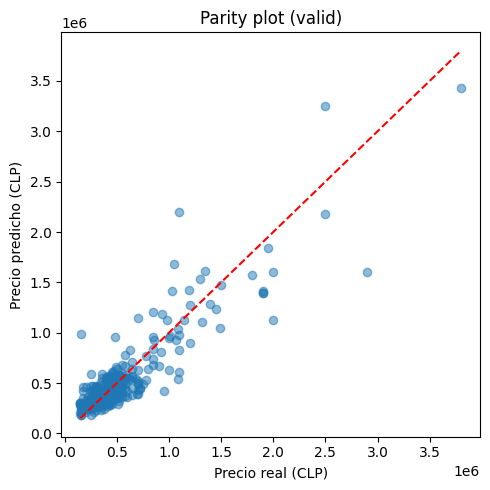

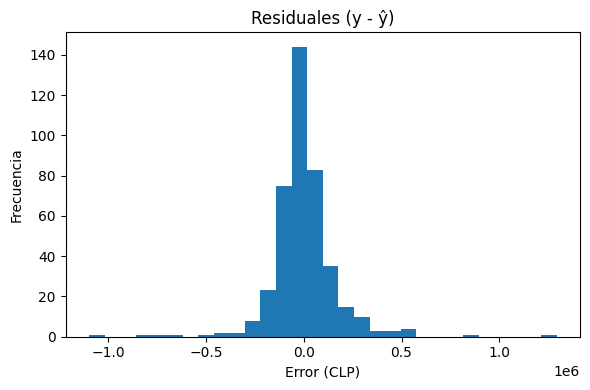

In [12]:
import matplotlib.pyplot as plt
resid = y_va - y_va_pred

# Convertir a CLP para visualización
y_va_clp = y_va * valor_uf
y_va_pred_clp = y_va_pred * valor_uf
resid_clp = resid * valor_uf

plt.figure(figsize=(5,5))
plt.scatter(y_va_clp, y_va_pred_clp, alpha=0.5)
mn, mx = min(y_va_clp.min(), y_va_pred_clp.min()), max(y_va_clp.max(), y_va_pred_clp.max())
plt.plot([mn,mx],[mn,mx],'--', color='red')
plt.xlabel("Precio real (CLP)")
plt.ylabel("Precio predicho (CLP)")
plt.title("Parity plot (valid)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(resid_clp, bins=30)
plt.title("Residuales (y - ŷ)")
plt.xlabel("Error (CLP)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

In [13]:
from sklearn.metrics import r2_score
y_tr_pred = rf.predict(X_tr)
print(f"R² train: {r2_score(y_tr, y_tr_pred):.3f}  |  R² valid: {r2:.3f}")

# Importancia de features
importancias = pd.DataFrame({
    'Feature': features,
    'Importancia': rf.feature_importances_
}).sort_values('Importancia', ascending=False)

print("\nImportancia de variables:")
print(importancias)

R² train: 0.893  |  R² valid: 0.799

Importancia de variables:
            Feature  Importancia
1  superficie_total     0.490666
0   superficie_util     0.354015
3             banos     0.125139
2       dormitorios     0.030180


# MAPA DE CALOR GEOGRÁFICO

In [ ]:
# OPTIMIZACIÓN: Reutilizar coordenadas ya calculadas en celda 6
print("=== PREPARACIÓN DE DATOS PARA MAPA ===")

# Transferir coordenadas y comuna desde df a df_arriendo
if 'lat' in df.columns and 'lon' in df.columns:
    # Hacer merge con df_arriendo usando el índice
    df_arriendo = df_arriendo.merge(
        df[['lat', 'lon', 'comuna_final']].rename(columns={'comuna_final': 'comuna'}),
        left_index=True, 
        right_index=True, 
        how='left',
        suffixes=('_old', '')
    )
    
    # Limpiar columnas duplicadas si existen
    if 'lat_old' in df_arriendo.columns:
        df_arriendo = df_arriendo.drop(columns=['lat_old', 'lon_old', 'comuna_old'], errors='ignore')
    
    coords_disponibles = df_arriendo[['lat', 'lon']].notna().all(axis=1).sum()
    print(f"✓ {coords_disponibles} registros con coordenadas ({coords_disponibles/len(df_arriendo)*100:.1f}%)")
    print(f"✓ Comunas únicas: {df_arriendo['comuna'].nunique()}")
    
    # Para registros sin coordenadas, usar coordenadas del diccionario de comunas
    sin_coords = df_arriendo[['lat', 'lon']].isna().any(axis=1)
    if sin_coords.sum() > 0:
        print(f"\n⚠️ {sin_coords.sum()} registros sin coordenadas")
        print("Asignando coordenadas desde diccionario de comunas...")
        
        for idx in df_arriendo[sin_coords].index:
            comuna = df_arriendo.loc[idx, 'comuna']
            if pd.notna(comuna) and comuna in coordenadas_comunas:
                lat, lon = coordenadas_comunas[comuna]
                df_arriendo.loc[idx, 'lat'] = lat
                df_arriendo.loc[idx, 'lon'] = lon
        
        coords_finales = df_arriendo[['lat', 'lon']].notna().all(axis=1).sum()
        print(f"✓ Coordenadas finales: {coords_finales} registros ({coords_finales/len(df_arriendo)*100:.1f}%)")
else:
    print("⚠️ No hay coordenadas precalculadas. Ejecuta primero la celda 6.")

print("\n✓ Datos listos para visualización")
print(f"Registros en df_arriendo: {len(df_arriendo)}")
print(f"Comunas en dataset: {df_arriendo['comuna'].value_counts().head(5).to_dict()}")

print(f"\nDistribución de comunas:")
print(df_arriendo['comuna'].value_counts())

display(df_arriendo[['comuna', 'lat', 'lon', 'precio']].head(10))



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Geocodificando direcciones (esto puede tardar varios minutos)...
Procesadas: 0/1653 (0.0%)
Procesadas: 50/1653 (3.0%)
Procesadas: 50/1653 (3.0%)
Procesadas: 100/1653 (6.0%)
Procesadas: 100/1653 (6.0%)
Procesadas: 150/1653 (9.1%)
Procesadas: 150/1653 (9.1%)
Procesadas: 200/1653 (12.1%)
Procesadas: 200/1653 (12.1%)
Procesadas: 250/1653 (15.1%)
Procesadas: 250/1653 (15.1%)
Procesadas: 300/1653 (18.1%)
Procesadas: 300/1653 (18.1%)
Procesadas: 350/1653 (21.2%)
Procesadas: 350/1653 (21.2%)
Procesadas: 400/1653 (24.2%)
Procesadas: 400/1653 (24.2%)
Procesadas: 450/1653 (27.2%)
Procesadas: 450/1653 (27.2%)
Procesadas: 500/1653 (30.2%)
Procesadas: 500/1653 (30.2%)
Procesadas: 550/1653 (33.3%)
Procesadas: 550/1653 (33.3%)
Procesadas: 600/1653 (36.3%)
Procesadas: 600/1653 (36.3%)
Procesadas: 650/1653 (39.3%)
Procesadas: 650/1653 (39.3%)
Procesadas: 700/1653 (42.3%)
Procesadas: 700/1653 (42.3%)
Procesadas: 750/1653 (45.4%)
Procesadas: 750/1653 (45.4%)
Procesadas: 800/1653 (48.4%)
Procesadas: 800/16

,comuna,lat,lon,precio
2,Otra,-33.448900,-70.669300,1300000
4,Otra,-33.448900,-70.669300,950000
5,Otra,-33.448900,-70.669300,335000
6,Santiago,-33.446505,-70.660975,425000
7,Ñuñoa,-33.467485,-70.596067,390000
11,Otra,-33.448900,-70.669300,750000
12,Otra,-33.448900,-70.669300,150000
13,Otra,-33.448900,-70.669300,250000
14,La Pintana,-33.572975,-70.628577,290000
16,Otra,-33.448900,-70.669300,280000


In [27]:
# Calcular distancia al metro más cercano
import numpy as np

# Estaciones de metro de Santiago (coordenadas reales - Líneas 1-6)
# Fuente: OpenStreetMap y datos oficiales Metro de Santiago
estaciones_metro = [
    # Línea 1 (Roja) - 27 estaciones
    (-33.4450, -70.7167),  # San Pablo
    (-33.4447, -70.7000),  # Neptuno
    (-33.4397, -70.6833),  # Pajaritos
    (-33.4386, -70.6753),  # Las Rejas
    (-33.4375, -70.6667),  # Ecuador
    (-33.4408, -70.6569),  # San Alberto Hurtado
    (-33.4456, -70.6506),  # Universidad de Santiago
    (-33.4492, -70.6483),  # Estación Central
    (-33.4528, -70.6461),  # ULA (Unión Latinoamericana)
    (-33.4456, -70.6419),  # República
    (-33.4428, -70.6333),  # Los Héroes
    (-33.4372, -70.6300),  # La Moneda
    (-33.4375, -70.6250),  # Universidad de Chile
    (-33.4389, -70.6197),  # Santa Lucía
    (-33.4400, -70.6144),  # Universidad Católica
    (-33.4489, -70.6093),  # Baquedano
    (-33.4550, -70.6028),  # Salvador
    (-33.4372, -70.6106),  # Manuel Montt
    (-33.4336, -70.6044),  # Pedro de Valdivia
    (-33.4306, -70.5986),  # Los Leones
    (-33.4167, -70.5917),  # Tobalaba
    (-33.4122, -70.5861),  # El Golf
    (-33.4083, -70.5806),  # Alcántara
    (-33.4166, -70.6000),  # Escuela Militar
    (-33.4042, -70.5694),  # Manquehue
    (-33.3997, -70.5625),  # Hernando de Magallanes
    (-33.3928, -70.5547),  # Los Dominicos
    
    # Línea 2 (Amarilla) - 26 estaciones
    (-33.3683, -70.6553),  # Vespucio Norte
    (-33.3867, -70.6553),  # Zapadores
    (-33.3972, -70.6553),  # Dorsal
    (-33.4072, -70.6553),  # Einstein
    (-33.4133, -70.6553),  # Cementerios
    (-33.4200, -70.6497),  # Cerro Blanco
    (-33.4267, -70.6419),  # Patronato
    (-33.4361, -70.6408),  # Puente Cal y Canto
    (-33.4400, -70.6378),  # Santa Ana
    (-33.4428, -70.6333),  # Los Héroes
    (-33.4478, -70.6336),  # Toesca
    (-33.4547, -70.6336),  # Parque O'Higgins
    (-33.4628, -70.6336),  # Rondizzoni
    (-33.4689, -70.6369),  # Franklin
    (-33.4803, -70.6403),  # El Llano
    (-33.4903, -70.6458),  # San Miguel
    (-33.4969, -70.6533),  # Lo Vial
    (-33.5050, -70.6594),  # Departamental
    (-33.5131, -70.6658),  # Ciudad del Niño
    (-33.5214, -70.6722),  # Lo Ovalle
    (-33.5292, -70.6781),  # El Parrón
    (-33.5331, -70.6678),  # La Cisterna
    (-33.5447, -70.6594),  # El Bosque
    (-33.5531, -70.6508),  # Observatorio
    (-33.5617, -70.6422),  # Copa Lo Martínez
    (-33.5728, -70.6286),  # Hospital El Pino
    
    # Línea 3 (Marrón) - 21 estaciones
    (-33.3611, -70.7306),  # Plaza Quilicura
    (-33.3694, -70.7194),  # Lo Cruzat
    (-33.3808, -70.7056),  # Ferrocarril
    (-33.3889, -70.6958),  # Los Libertadores
    (-33.3992, -70.6847),  # Cardenal Caro
    (-33.4083, -70.6742),  # Vivaceta
    (-33.4161, -70.6658),  # Conchalí
    (-33.4236, -70.6583),  # Plaza Chacabuco
    (-33.4300, -70.6517),  # Hospitales
    (-33.4361, -70.6408),  # Puente Cal y Canto
    (-33.4392, -70.6375),  # Plaza de Armas
    (-33.4425, -70.6342),  # Universidad de Chile
    (-33.4522, -70.6244),  # Parque Almagro
    (-33.4600, -70.6167),  # Matta
    (-33.4694, -70.6069),  # Irarrázaval
    (-33.4753, -70.6008),  # Monseñor Eyzaguirre
    (-33.4569, -70.5978),  # Ñuñoa
    (-33.4828, -70.5931),  # Chile España
    (-33.4892, -70.5869),  # Villa Frei
    (-33.4500, -70.5333),  # Plaza Egaña
    (-33.5006, -70.5747),  # Fernando Castillo Velasco
    
    # Línea 4 (Azul) - 23 estaciones
    (-33.4167, -70.5917),  # Tobalaba
    (-33.4236, -70.5842),  # Cristóbal Colón
    (-33.4308, -70.5764),  # Francisco Bilbao
    (-33.4500, -70.5333),  # Plaza Egaña
    (-33.4500, -70.5450),  # Simón Bolívar
    (-33.4581, -70.5569),  # Los Orientales
    (-33.4653, -70.5647),  # Grecia
    (-33.4969, -70.5167),  # Los Presidentes
    (-33.4789, -70.5831),  # Quilín
    (-33.4869, -70.5911),  # Las Torres
    (-33.4914, -70.5978),  # Macul
    (-33.4989, -70.6050),  # Cam. Agrícola
    (-33.5050, -70.6119),  # San Joaquín
    (-33.5111, -70.6186),  # Pedrero
    (-33.5175, -70.6253),  # Mirador
    (-33.5242, -70.5989),  # Vicente Valdés
    (-33.5317, -70.6050),  # Rojas Magallanes
    (-33.5389, -70.6111),  # Trinidad
    (-33.5461, -70.6172),  # San José de la Estrella
    (-33.5539, -70.6236),  # Los Quillayes
    (-33.5614, -70.6300),  # Elisa Correa
    (-33.5686, -70.6361),  # Hospital Sótero del Río
    (-33.5989, -70.5758),  # Protectora de la Infancia
    (-33.6075, -70.5775),  # Las Mercedes
    (-33.6167, -70.5833),  # Plaza de Puente Alto
    
    # Línea 4A (Celeste) - 6 estaciones
    (-33.5111, -70.6186),  # Vicuña Mackenna
    (-33.5197, -70.6258),  # Santa Julia
    (-33.5269, -70.6328),  # La Granja
    (-33.5333, -70.6394),  # Santa Rosa
    (-33.5394, -70.6458),  # San Ramón
    (-33.5331, -70.6678),  # La Cisterna
    
    # Línea 5 (Verde) - 30 estaciones
    (-33.5108, -70.7578),  # Plaza de Maipú
    (-33.5067, -70.7492),  # Santiago Bueras
    (-33.5025, -70.7408),  # Del Sol
    (-33.4981, -70.7322),  # Monte Tabor
    (-33.4933, -70.7233),  # Las Parcelas
    (-33.4881, -70.7142),  # Laguna Sur
    (-33.4403, -70.7500),  # Pudahuel
    (-33.4483, -70.7389),  # San Pablo
    (-33.4572, -70.7275),  # Lo Prado
    (-33.4669, -70.7158),  # Blanqueado
    (-33.4756, -70.7044),  # Gruta de Lourdes
    (-33.4844, -70.6931),  # Quinta Normal
    (-33.4400, -70.6378),  # Santa Ana
    (-33.4392, -70.6375),  # Plaza de Armas
    (-33.4375, -70.6300),  # Bellas Artes
    (-33.4489, -70.6093),  # Baquedano
    (-33.4550, -70.6028),  # Parque Bustamante
    (-33.4639, -70.5939),  # Santa Isabel
    (-33.4722, -70.5850),  # Irarrázaval
    (-33.4803, -70.5764),  # Ñuble
    (-33.4881, -70.5678),  # Rodrigo de Araya
    (-33.4958, -70.5594),  # Carlos Valdovinos
    (-33.5042, -70.5503),  # Camino Agrícola
    (-33.5111, -70.6186),  # San Joaquín
    (-33.5194, -70.6203),  # Pedrero
    (-33.5275, -70.6219),  # Mirador
    (-33.5242, -70.5989),  # Bellavista de La Florida
    (-33.5331, -70.5903),  # Vicente Valdés
    (-33.5419, -70.5817),  # Rojas Magallanes
    (-33.5506, -70.5731),  # Las Mercedes
    
    # Línea 6 (Morado) - 10 estaciones
    (-33.4972, -70.7167),  # Cerrillos
    (-33.4889, -70.7053),  # Lo Valledor
    (-33.4806, -70.6939),  # Pte. Pdte. Pedro Aguirre Cerda
    (-33.4689, -70.6369),  # Franklin
    (-33.4622, -70.6297),  # Bío-Bío
    (-33.4881, -70.5678),  # Ñuble
    (-33.4728, -70.5772),  # Estadio Nacional
    (-33.4569, -70.5978),  # Ñuñoa
    (-33.4450, -70.6083),  # Inés de Suárez
    (-33.4306, -70.5986),  # Los Leones
]

def calcular_distancia_haversine(lat1, lon1, lat2, lon2):
    """Distancia en km usando fórmula de Haversine"""
    R = 6371  # Radio de la Tierra en km
    
    lat1_rad = np.radians(lat1)
    lat2_rad = np.radians(lat2)
    delta_lat = np.radians(lat2 - lat1)
    delta_lon = np.radians(lon2 - lon1)
    
    a = np.sin(delta_lat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(delta_lon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    return R * c

def distancia_metro_mas_cercano(lat, lon):
    """Calcula distancia al metro más cercano en km"""
    if pd.isna(lat) or pd.isna(lon):
        return np.nan
    
    distancias = [calcular_distancia_haversine(lat, lon, est[0], est[1]) for est in estaciones_metro]
    return min(distancias)

df_arriendo['dist_metro_km'] = df_arriendo.apply(
    lambda row: distancia_metro_mas_cercano(row['lat'], row['lon']), 
    axis=1
)

print(f"✓ Distancias calculadas con {len(estaciones_metro)} estaciones de metro (Líneas 1-6)")
print(f"  Distancia promedio al metro: {df_arriendo['dist_metro_km'].mean():.2f} km")
print(f"  Distancia mínima: {df_arriendo['dist_metro_km'].min():.2f} km")
print(f"  Distancia máxima: {df_arriendo['dist_metro_km'].max():.2f} km")
print(f"  Propiedades a <500m del metro: {(df_arriendo['dist_metro_km'] < 0.5).sum()} ({(df_arriendo['dist_metro_km'] < 0.5).sum()/len(df_arriendo)*100:.1f}%)")


✓ Distancias calculadas con 145 estaciones de metro (Líneas 1-6)
  Distancia promedio al metro: 1.26 km
  Distancia mínima: 0.02 km
  Distancia máxima: 2.72 km
  Propiedades a <500m del metro: 17 (1.0%)


In [29]:
# Agregar variables socioeconómicas por comuna
# Datos aproximados de población e ingresos (INE 2023) - TODAS las 52 comunas de la RM
datos_socioeconomicos = {
    # Zona Oriente (alto ingreso)
    'Providencia': {'poblacion': 142079, 'ingreso_medio': 1800000},
    'Las Condes': {'poblacion': 330759, 'ingreso_medio': 2500000},
    'Vitacura': {'poblacion': 96774, 'ingreso_medio': 3000000},
    'Ñuñoa': {'poblacion': 208237, 'ingreso_medio': 1500000},
    'La Reina': {'poblacion': 100252, 'ingreso_medio': 1700000},
    'Lo Barnechea': {'poblacion': 124076, 'ingreso_medio': 2200000},
    'Peñalolén': {'poblacion': 266798, 'ingreso_medio': 850000},
    'Macul': {'poblacion': 134635, 'ingreso_medio': 950000},
    'La Florida': {'poblacion': 402433, 'ingreso_medio': 900000},
    
    # Zona Centro
    'Santiago': {'poblacion': 503147, 'ingreso_medio': 800000},
    'Independencia': {'poblacion': 142065, 'ingreso_medio': 750000},
    'Recoleta': {'poblacion': 190075, 'ingreso_medio': 800000},
    'Conchalí': {'poblacion': 139195, 'ingreso_medio': 700000},
    'Huechuraba': {'poblacion': 112528, 'ingreso_medio': 950000},
    'Quinta Normal': {'poblacion': 136368, 'ingreso_medio': 750000},
    'Estación Central': {'poblacion': 206792, 'ingreso_medio': 800000},
    'Cerrillos': {'poblacion': 88956, 'ingreso_medio': 850000},
    'Maipú': {'poblacion': 578605, 'ingreso_medio': 950000},
    'Pudahuel': {'poblacion': 253139, 'ingreso_medio': 750000},
    'Lo Prado': {'poblacion': 104316, 'ingreso_medio': 650000},
    'Renca': {'poblacion': 160847, 'ingreso_medio': 650000},
    'Quilicura': {'poblacion': 254694, 'ingreso_medio': 900000},
    'Cerro Navia': {'poblacion': 142465, 'ingreso_medio': 600000},
    
    # Zona Sur
    'San Miguel': {'poblacion': 133059, 'ingreso_medio': 900000},
    'La Cisterna': {'poblacion': 100434, 'ingreso_medio': 850000},
    'San Joaquín': {'poblacion': 103485, 'ingreso_medio': 850000},
    'Pedro Aguirre Cerda': {'poblacion': 107803, 'ingreso_medio': 700000},
    'Lo Espejo': {'poblacion': 103865, 'ingreso_medio': 650000},
    'San Ramón': {'poblacion': 92312, 'ingreso_medio': 650000},
    'La Granja': {'poblacion': 122557, 'ingreso_medio': 650000},
    'El Bosque': {'poblacion': 172000, 'ingreso_medio': 650000},
    'La Pintana': {'poblacion': 189335, 'ingreso_medio': 600000},
    'San Bernardo': {'poblacion': 334836, 'ingreso_medio': 750000},
    'Puente Alto': {'poblacion': 645909, 'ingreso_medio': 750000},
    
    # Zona Norte
    'Colina': {'poblacion': 180353, 'ingreso_medio': 800000},
    'Lampa': {'poblacion': 127281, 'ingreso_medio': 750000},
    'Tiltil': {'poblacion': 20385, 'ingreso_medio': 600000},
    
    # Zona Oeste
    'Curacaví': {'poblacion': 36430, 'ingreso_medio': 650000},
    'María Pinto': {'poblacion': 14926, 'ingreso_medio': 600000},
    'Melipilla': {'poblacion': 141165, 'ingreso_medio': 700000},
    'San Pedro': {'poblacion': 10588, 'ingreso_medio': 550000},
    'Alhué': {'poblacion': 6676, 'ingreso_medio': 500000},
    'Talagante': {'poblacion': 78675, 'ingreso_medio': 750000},
    'El Monte': {'poblacion': 40014, 'ingreso_medio': 650000},
    'Isla de Maipo': {'poblacion': 40171, 'ingreso_medio': 700000},
    'Padre Hurtado': {'poblacion': 75080, 'ingreso_medio': 800000},
    'Peñaflor': {'poblacion': 96729, 'ingreso_medio': 750000},
    
    # Zona Sur (Cordillera)
    'Pirque': {'poblacion': 30433, 'ingreso_medio': 1200000},
    'San José de Maipo': {'poblacion': 18644, 'ingreso_medio': 900000},
    
    # Zona Suroeste
    'Buin': {'poblacion': 109641, 'ingreso_medio': 700000},
    'Paine': {'poblacion': 82766, 'ingreso_medio': 650000},
    'Calera de Tango': {'poblacion': 27970, 'ingreso_medio': 700000},
    
    # Fallback
    'Otra': {'poblacion': 150000, 'ingreso_medio': 900000}
}

df_arriendo['poblacion_comuna'] = df_arriendo['comuna'].map(lambda c: datos_socioeconomicos.get(c, {}).get('poblacion', 150000))
df_arriendo['ingreso_medio_comuna'] = df_arriendo['comuna'].map(lambda c: datos_socioeconomicos.get(c, {}).get('ingreso_medio', 900000))

print("Variables socioeconómicas agregadas:")
print(f"Total comunas con datos: {len(datos_socioeconomicos)}")
display(df_arriendo[['comuna', 'poblacion_comuna', 'ingreso_medio_comuna', 'dist_metro_km']].head(10))


Variables socioeconómicas agregadas:
Total comunas con datos: 53


,comuna,poblacion_comuna,ingreso_medio_comuna,dist_metro_km
2,Otra,150000,900000,1.273440
4,Otra,150000,900000,1.273440
5,Otra,150000,900000,1.273440
6,Santiago,503147,800000,0.738449
7,Ñuñoa,208237,1500000,0.446417
11,Otra,150000,900000,1.273440
12,Otra,150000,900000,1.273440
13,Otra,150000,900000,1.273440
14,La Pintana,189335,600000,0.019556
16,Otra,150000,900000,1.273440


In [22]:
# Mapa de calor con folium
import folium
from folium.plugins import HeatMap

# Calcular precio promedio por comuna (en CLP para visualización)
precio_comuna = df_arriendo.groupby('comuna')['precio'].mean().sort_values(ascending=False)

# Crear mapa centrado en Santiago
mapa = folium.Map(location=[-33.4489, -70.6693], zoom_start=11, tiles='CartoDB positron')

# Preparar datos para heatmap
heat_data = []
for comuna, precio_promedio in precio_comuna.items():
    if comuna in coordenadas_comunas and not pd.isna(precio_promedio):
        lat, lon = coordenadas_comunas[comuna]
        intensidad = min(precio_promedio / precio_comuna.max(), 1.0)
        heat_data.append([lat, lon, intensidad])
        
        # Info adicional
        info_comuna = datos_socioeconomicos.get(comuna, {})
        n_props = len(df_arriendo[df_arriendo['comuna']==comuna])
        
        popup_html = f"""
        <div style="font-family: Arial; width: 220px;">
            <h4 style="margin: 0 0 10px 0; color: #2c3e50;">{comuna}</h4>
            <p style="margin: 5px 0;"><b>Precio Promedio:</b> ${precio_promedio:,.0f}</p>
            <p style="margin: 5px 0;"><b>Propiedades:</b> {n_props}</p>
            <p style="margin: 5px 0;"><b>Ingreso medio:</b> ${info_comuna.get('ingreso_medio', 0):,.0f}</p>
            <p style="margin: 5px 0;"><b>Población:</b> {info_comuna.get('poblacion', 0):,}</p>
        </div>
        """
        
        # Color según precio
        if precio_promedio > precio_comuna.quantile(0.75):
            color = 'red'
        elif precio_promedio > precio_comuna.median():
            color = 'orange'
        else:
            color = 'green'
        
        folium.CircleMarker(
            location=[lat, lon],
            radius=10,
            popup=folium.Popup(popup_html, max_width=250),
            color=color,
            fill=True,
            fillColor=color,
            fillOpacity=0.7,
            weight=2
        ).add_to(mapa)

# Agregar heatmap
HeatMap(heat_data, radius=25, blur=35, 
        gradient={0.4: 'blue', 0.65: 'lime', 0.8: 'orange', 1.0: 'red'},
        min_opacity=0.3).add_to(mapa)

mapa.save('mapa_precios_santiago.html')
print("Mapa guardado en 'mapa_precios_santiago.html'")
mapa

Mapa guardado en 'mapa_precios_santiago.html'


# VALIDACION

In [13]:
# Reentrenar con todo el set
rf_full = RandomForestRegressor(
    n_estimators=600, random_state=42, n_jobs=-1, min_samples_leaf=2
)
rf_full.fit(imp.fit_transform(df_trainable[features].values), y_all)

# Ejemplo de predicción con nuevas features
sup_util = 140.0
sup_total = sup_util * ratio_mediana if "superficie_total" in features else None

# Usar comuna de referencia (Providencia)
comuna_ref = 'Providencia'
lat_ref, lon_ref = coordenadas_comunas[comuna_ref]
dist_metro_ref = distancia_metro_mas_cercano(lat_ref, lon_ref)
ingreso_ref = datos_socioeconomicos[comuna_ref]['ingreso_medio']
pob_ref = datos_socioeconomicos[comuna_ref]['poblacion']

ejemplo = {}
for f in features:
    if f == "superficie_util":         ejemplo[f] = sup_util
    elif f == "superficie_total":      ejemplo[f] = sup_total
    elif f == "dormitorios":           ejemplo[f] = 4
    elif f == "banos":                 ejemplo[f] = 2
    elif f == "lat":                   ejemplo[f] = lat_ref
    elif f == "lon":                   ejemplo[f] = lon_ref
    elif f == "dist_metro_km":         ejemplo[f] = dist_metro_ref
    elif f == "ingreso_medio_comuna":  ejemplo[f] = ingreso_ref
    elif f == "poblacion_comuna":      ejemplo[f] = pob_ref

X_ex = imp.transform(pd.DataFrame([ejemplo], columns=features).values)
pred_uf = rf_full.predict(X_ex)[0]
pred_clp = pred_uf * valor_uf

print(f"Consulta: 4 dorm, 2 baños, 140 m² útil en {comuna_ref}")
print(f"Precio estimado: {pred_uf:.2f} UF (~${pred_clp:,.0f} CLP)")
print(f"Distancia al metro: {dist_metro_ref:.2f} km")
print(f"\nVector usado: {ejemplo}")

NameError: name 'RandomForestRegressor' is not defined